<a href="https://colab.research.google.com/github/Sachin270/CMLAssignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
while True:pass

KeyboardInterrupt: ignored

In [4]:
!ls /content/drive/'MyDrive'/'Colab Notebooks'/

 Assignment2_s3714805.ipynb	      patch_images      Untitled2.ipynb
 data_labels_extraData.csv	      Untitled	       'Untitled8 (1).ipynb'
 data_labels_mainData.csv	      Untitled0.ipynb   Untitled8.ipynb
'Image_classification_data (1).zip'   Untitled1.ipynb


In [5]:
!cp /content/drive/'MyDrive'/'Colab Notebooks'/'Image_classification_data (1).zip' .
!unzip -q -o 'Image_classification_data (1).zip'
!rm 'Image_classification_data (1).zip'
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [6]:
#Uncomment if on loca machine or AWS
# import zipfile
# with zipfile.ZipFile('./Image_classification_data (1).zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4


# Uncomment the following line to do two class classification with
# a subset of data
# data = data[(data['Class'] == 3) | (data['Class'] == 5)]
# OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [7]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 50

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [8]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])

    plt.show()

In [9]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [11]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [12]:
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25)

Epoch 1/25
119/119 [==============================] - 33s 33ms/step - loss: 1.0897 - sparse_categorical_accuracy: 0.5333 - val_loss: 1.0134 - val_sparse_categorical_accuracy: 0.6028
Epoch 2/25
119/119 [==============================] - 3s 28ms/step - loss: 0.8135 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.7023 - val_sparse_categorical_accuracy: 0.7196
Epoch 3/25
119/119 [==============================] - 3s 28ms/step - loss: 0.7648 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.7381 - val_sparse_categorical_accuracy: 0.7014
Epoch 4/25
119/119 [==============================] - 3s 29ms/step - loss: 0.6877 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.7473
Epoch 5/25
119/119 [==============================] - 3s 29ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.7393
Epoch 6/25
119/119 [==============================] - 3s 29ms/step - loss: 0.6512 - sparse_cat

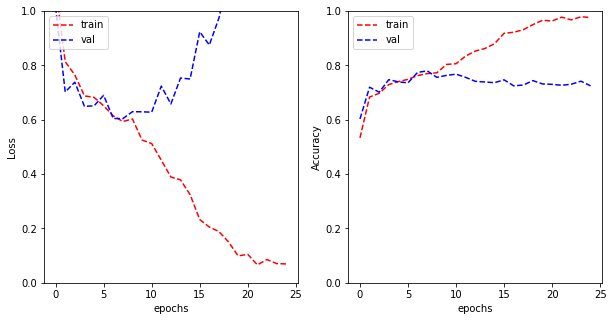

In [13]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['sparse_categorical_accuracy'], history_VGG_1.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=100)
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['sparse_categorical_accuracy'], history_VGG_2.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_2.evaluate(validation_generator)

40/40 [==============================] - 1s 19ms/step - loss: 1.4398 - sparse_categorical_accuracy: 0.7458


[1.4398329257965088, 0.7458312511444092]

In [ ]:
test_data['Class'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.7283


[1.578864574432373, 0.7282828092575073]

In [6]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [7]:
import tensorflow as tf
reg_lambda = 0.00001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [8]:

model_VGG_3.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model_VGG_3.optimizer.get_config()

In [ ]:
history_VGG_3 = model_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=100)

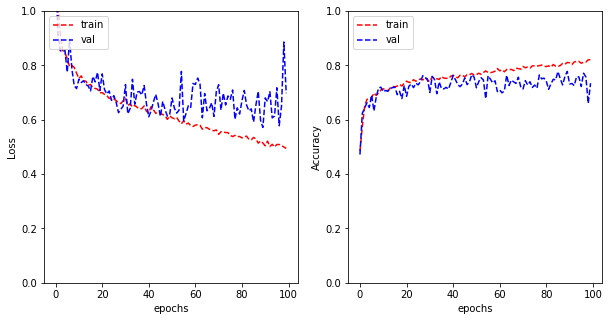

In [12]:
plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['sparse_categorical_accuracy'], history_VGG_3.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_3.evaluate(validation_generator)

74/74 [==============================] - 1s 11ms/step - loss: 0.7381 - sparse_categorical_accuracy: 0.7433


[0.7381166815757751, 0.7433046698570251]

In [ ]:
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.7703514739229025
F1 score:  0.7089611032527133
[[ 8881   716   425   213]
 [ 1365 11107   745   348]
 [ 2620   725 18295    26]
 [ 2144  2292   534  2484]]


In [65]:
#Uncomment if on loca machine or AWS
# import zipfile
# with zipfile.ZipFile('./Image_classification_data (1).zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 2


# Uncomment the following line to do two class classification with
# a subset of data
# data = data[(data['Class'] == 3) | (data['Class'] == 5)]
# OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [66]:
train_data['Class'] = train_data['isCancerous'].astype('str')
val_data['Class'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [67]:
import tensorflow as tf
reg_lambda = 0.0001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [68]:
model_VGG_3.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [69]:
history_VGG_3 = model_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=100)

Epoch 1/15
220/220 [==============================] - 7s 29ms/step - loss: 0.6702 - categorical_accuracy: 0.6249 - val_loss: 0.4695 - val_categorical_accuracy: 0.7938
Epoch 2/15
220/220 [==============================] - 6s 28ms/step - loss: 0.4293 - categorical_accuracy: 0.8285 - val_loss: 0.5698 - val_categorical_accuracy: 0.7261
Epoch 3/15
220/220 [==============================] - 6s 28ms/step - loss: 0.3931 - categorical_accuracy: 0.8471 - val_loss: 0.4153 - val_categorical_accuracy: 0.8034
Epoch 4/15
220/220 [==============================] - 6s 28ms/step - loss: 0.3836 - categorical_accuracy: 0.8457 - val_loss: 0.3399 - val_categorical_accuracy: 0.8615
Epoch 5/15
220/220 [==============================] - 6s 28ms/step - loss: 0.3746 - categorical_accuracy: 0.8503 - val_loss: 0.3066 - val_categorical_accuracy: 0.8802
Epoch 6/15
220/220 [==============================] - 6s 28ms/step - loss: 0.3590 - categorical_accuracy: 0.8570 - val_loss: 0.3469 - val_categorical_accuracy: 0.846

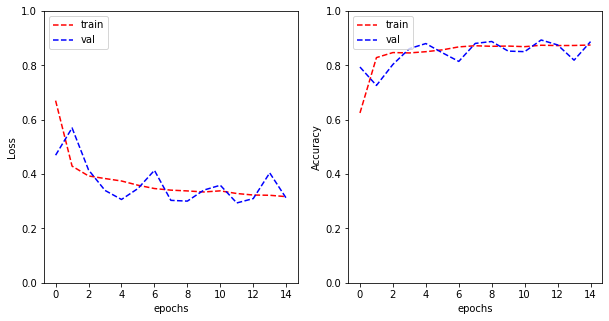

In [70]:
plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9137693078479194
F1 score:  0.9092785580010481
[[30050  1201]
 [ 3360 18282]]


In [71]:
model_VGG_3.save("model_VGG_3")

INFO:tensorflow:Assets written to: model_VGG_3/assets


In [ ]:
## Only on colab
# Change according to your directory structure
!cp -R ./model_VGG_3 /content/drive/'MyDrive'/'Colab Notebooks'/

In [72]:
#Uncomment if on loca machine or AWS
# import zipfile
# with zipfile.ZipFile('./Image_classification_data (1).zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4


# Uncomment the following line to do two class classification with
# a subset of data
# data = data[(data['Class'] == 3) | (data['Class'] == 5)]
# OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [73]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 50

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
model_VGG_3.summary()

In [80]:
from tensorflow.keras.layers import Dense
model_VGG_3.pop()

In [ ]:
model_VGG_3.summary()

In [78]:
model_VGG_3.add(Dense(4, activation='softmax'))

In [85]:
model_VGG_3.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [87]:
history_VGG_3 = model_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=100)

Epoch 1/100
119/119 [==============================] - 2s 19ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.7608 - val_loss: 0.6625 - val_sparse_categorical_accuracy: 0.7524
Epoch 2/100
119/119 [==============================] - 2s 19ms/step - loss: 0.6687 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.7196
Epoch 3/100
119/119 [==============================] - 2s 19ms/step - loss: 0.6453 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.6315 - val_sparse_categorical_accuracy: 0.7681
Epoch 4/100
119/119 [==============================] - 2s 19ms/step - loss: 0.6423 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.6390 - val_sparse_categorical_accuracy: 0.7610
Epoch 5/100
119/119 [==============================] - 2s 19ms/step - loss: 0.6449 - sparse_categorical_accuracy: 0.7618 - val_loss: 0.6309 - val_sparse_categorical_accuracy: 0.7665
Epoch 6/100
119/119 [==============================] - 2s 20ms/step - loss: 0.6360 - spars